In [1]:
import pandas as pd
import geopandas as gpd
from shapely import MultiPoint
import itertools
import os
import shutil
import zipfile
import subprocess

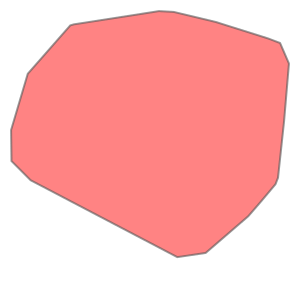

In [2]:
milan_buildings_polys = gpd.read_file("data/footprints/Milano.shp").geometry
milan_buildings_points = [building.convex_hull.exterior.coords for building in milan_buildings_polys]
outer_milan = MultiPoint(list(itertools.chain.from_iterable(milan_buildings_points))).convex_hull.buffer(-1e-9)
gpd.GeoDataFrame(pd.DataFrame([{"id": "0"}]), geometry=[outer_milan],crs="EPSG:7791").to_file("data/coverage.shp")
outer_milan

In [ ]:
sample_input_gdf = gpd.read_file("data/coverage.shp").to_crs("EPSG:4326")
sample_coverage = list(sample_input_gdf["geometry"])[0]
CONTRACT_NUMBER = 145

# Specify intersection
contract_data = gpd.read_file(f"metadata/contract_{CONTRACT_NUMBER}/metadata_contract_{CONTRACT_NUMBER}.shp")

def get_intersection_tiles(input_polygon, lidar_coverage):
    intersection_array = lidar_coverage.geometry.map(lambda x: x.intersects(input_polygon))
    return lidar_coverage[intersection_array][["id", "region"]]

intersection = get_intersection_tiles(sample_coverage, contract_data)

# Copy files from HDD
source_path_prefix = "/Volumes/Seagate Expansion Drive/just_points"
destination_path_prefix = "data/lidar_points/raw"

def get_point_file_path(region, contract, filename):
    return os.path.join(source_path_prefix, region, f"Contratto_{contract}", "PUNTI", f"{filename}.zip")

files_to_copy = [get_point_file_path(row["region"], str(CONTRACT_NUMBER), row["id"]) for _, row in intersection.iterrows()]
for filepath in files_to_copy:
    dst = os.path.join(destination_path_prefix, filepath.split("/")[-1])
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copy(filepath, dst)

# Extract Zips
for filename in os.listdir(destination_path_prefix):  
    filepath = os.path.join(destination_path_prefix, filename)
    if zipfile.is_zipfile(filepath):
        with zipfile.ZipFile(filepath) as item:
           item.extractall(destination_path_prefix) 

# Remove Zips
for filename in os.listdir(destination_path_prefix): 
    if filename.endswith("zip"):
        os.remove(os.path.join(destination_path_prefix, filename))


In [2]:
footprints_raw = gpd.read_file("data/footprints/Milano.shp").to_crs("EPSG:4326")
coverage_140 = gpd.read_file("metadata/contract_140/metadata_contract_140.shp")
coverage_145 = gpd.read_file("metadata/contract_145/metadata_contract_145.shp")

def prepare_points(points_filename):
    points = pd.read_csv(f"data/lidar_points/{points_filename}.xyz", names=["long","lat","elevation","_1","_2"], delim_whitespace=True)
    points = points[["long","lat", "elevation"]].rename(columns={'lat': 'x', 'long': 'y', 'elevation': 'z'})
    points.insert(0, 'id', range(0, len(points)))
    path = f"data/tmp/points_{points_filename}.csv"
    points.to_csv(path, index=False)
    return path

def prepare_footprints(points_filename):
    coverage_tiles_140 = list(coverage_140[coverage_140["id"] == points_filename].geometry)
    coverage_tiles_145 = list(coverage_145[coverage_145["id"] == points_filename].geometry)
    
    coverage_tile = coverage_tiles_140[0] if coverage_tiles_140 else coverage_tiles_145[0]
    footprints_intersection = footprints_raw.geometry.map(lambda x: x.intersects(coverage_tile))
    footprints = footprints_raw[footprints_intersection][["OBJECTID", "edifc_stat", "edifc_ty", "edifc_uso", "geometry"]]\
        .rename(columns={'OBJECTID': 'id'})
    path = f"data/tmp/footprints_{points_filename}.csv"
    footprints.to_csv(path, index=False)
    return path

In [6]:
points_files = [f for f in os.listdir("data/lidar_points/") if f.endswith("xyz")]
for filename in points_files: #['D45420917_0101_Punti.xyz']
    points_filename = filename[:-4]
    print(points_filename)
    if not f"{points_filename}.csv" in os.listdir("data/postgis_output/"):
        points_path = prepare_points(points_filename)
        footprints_path = prepare_footprints(points_filename)
        output_path = f"data/postgis_output/{points_filename}.csv"
        os.system(f"./postgis_processing.sh {points_path} {footprints_path} {output_path}")
        os.remove(footprints_path)
        os.remove(points_path)

D45440915_0101_Punti
D45500925_0101_Punti
D45470914_0101_Punti
D45420917_0101_Punti
D45490915_0101_Punti
D45410916_0101_Punti
e1140682f02b484d7bd72c808b10a469dd2e996eb8752f798c25c1537ca8969a
CREATE TABLE
CREATE TABLE
COPY 1538968
UPDATE 1538968
COPY 102
UPDATE 102
UPDATE 102
COPY 102
skynet
skynet
D45450926_0101_Punti
74404e733ce344f6a43d86f8ae35cfd37664b29c7c690c74353d75fe26d94f14
CREATE TABLE
CREATE TABLE
COPY 1480270
UPDATE 1480270
COPY 31
UPDATE 31
UPDATE 31
COPY 31
skynet
skynet
D45510916_0101_Punti
2516909a35c451503b133b7d0f9713a1e440f56e3f23f539bf38d60374e81cc6
CREATE TABLE
CREATE TABLE
COPY 1769504
UPDATE 1769504
COPY 338
UPDATE 338
UPDATE 338
COPY 338
skynet
skynet
D45520917_0101_Punti
960c448751d5d49ae7bd974b751a8d95c0df6a9fa08edfd982f084f6bf1897db
CREATE TABLE
CREATE TABLE
COPY 3453652
UPDATE 3453652
COPY 496
UPDATE 496
UPDATE 496
COPY 496
skynet
skynet
D45460927_0101_Punti
10a841a58c87dbb066a75a2ef9394946c82fef38d37b1a0829a4e1e18a6a54e7
CREATE TABLE
CREATE TABLE
COPY 552643

psql:/tmp/preprocessing.sql:12: ERROR:  type "geometry" does not exist
LINE 7:     geometry geometry(Point, 4326),
                     ^
psql:/tmp/preprocessing.sql:24: ERROR:  type "geometry" does not exist
LINE 8:     geometry geometry(MultiPolygon,4326),
                     ^
psql:/tmp/preprocessing.sql:29: ERROR:  relation "points" does not exist
psql:/tmp/preprocessing.sql:31: ERROR:  relation "points" does not exist
LINE 1: update points set geometry = ST_MakePoint(x, y), final_geome...
               ^
psql:/tmp/preprocessing.sql:36: ERROR:  relation "footprints" does not exist
psql:/tmp/preprocessing.sql:38: ERROR:  relation "footprints" does not exist
LINE 1: update footprints set geometry = ST_Multi(ST_GeomFromText(ge...
               ^
psql:/tmp/preprocessing.sql:39: ERROR:  relation "footprints" does not exist
LINE 1: update footprints set buffered_geometry = ST_Buffer(geometry...
               ^
psql:/tmp/preprocessing.sql:103: ERROR:  relation "footprints" does not ex

skynet
skynet
D45410911_0101_Punti
e443ba27e2f9cb525e64082cf2855c71be9bbe9042078ca13c15a9e24778f632


Error response from daemon: Container e443ba27e2f9cb525e64082cf2855c71be9bbe9042078ca13c15a9e24778f632 is not running
Error: No such container:path: skynet:/tmp/output_data.csv


skynet
skynet
D45490907_0101_Punti
